---
# 3. RECOMENDADOR BASADO EN LDA

<div style="text-align: justify;">

En esta sección desarrollamos un sistema de recomendación basado en LDA. Desde el principio, nos hemos centrado en procesar las descripciones de los libros para extraer información temática que nos permita entender la estructura subyacente de los textos y, a partir de ello, generar recomendaciones que se basen en similitudes de contenido.

Inicialmente, hemos trabajado con un dataset en el que aplicamos diversas técnicas de preprocesamiento. Empezamos tokenizando las descripciones con la función `sent_to_words`, lo que nos permitió transformar cada descripción en una lista de palabras en minúsculas, eliminando puntuación y caracteres especiales. Posteriormente, decidimos eliminar las stopwords utilizando la lista en inglés de NLTK, ya que estas palabras, por su alta frecuencia, aportan poco valor al análisis temático. Con estas acciones, logramos reducir el ruido en los datos, centrándonos en los términos que realmente definen cada texto.

Además, incorporamos el uso de bigrams mediante el modelo de Gensim, lo que nos permitió detectar y combinar palabras que, al formar una unidad, capturan mejor conceptos o expresiones significativas en el corpus. Este paso es esencial para captar las combinaciones más representativas del lenguaje que pueden ser decisivas para diferenciar temas. Complementariamente, aplicamos un proceso de lematización con spaCy, restringido a las categorías gramaticales relevantes (sustantivos, adjetivos, verbos y adverbios), lo que nos ayudó a normalizar las palabras y a reducir la variabilidad léxica del corpus.

Una vez preprocesado el texto, procedimos a construir el modelo LDA. Creamos un diccionario que asocia cada palabra única a un identificador y generamos el corpus en formato bag-of-words, lo que nos permitió cuantificar la presencia de cada término en los documentos. Con este corpus, entrenamos un modelo LDA utilizando `LdaMulticore` de Gensim, eligiendo parámetros como el número de temas, el tamaño de los chunks y el número de pasadas para asegurar una convergencia adecuada. La elección de parámetros como `alpha` y `eta` fue fundamental para ajustar la distribución previa de temas por documento y la dispersión de palabras por tema, lo que repercute directamente en la calidad interpretativa de los tópicos generados.

Asimismo, evaluamos nuestro modelo mediante el cálculo de la coherencia, una métrica que nos permite cuantificar la consistencia semántica de los temas identificados. Esto nos brindó una medida objetiva para ajustar el número de tópicos y optimizar el modelo. La visualización interactiva mediante pyLDAvis, por otro lado, nos ha permitido explorar en detalle la distribución de los temas, facilitando la interpretación y validación de los resultados.

Finalmente, asignamos a cada documento su tópico principal, integrando esta información en nuestro dataset para utilizarla en el sistema de recomendación. De este modo, cuando se selecciona un libro, podemos recomendar otros con temáticas similares basándonos en la asignación de tópicos, lo que enriquece la experiencia del usuario al proporcionar sugerencias coherentes y contextualmente relevantes.

En resumen, este enfoque con LDA se fundamenta en una rigurosa preparación del texto—mediante tokenización, eliminación de stopwords, generación de bigrams y lematización—, seguida de la construcción y ajuste del modelo temático para extraer patrones semánticos. Todo ello se combina con técnicas de visualización y evaluación que nos permiten validar la calidad de los tópicos, y finalmente, integrar estos resultados en un sistema de recomendación que ofrece sugerencias literarias basadas en la similitud de contenidos.

</div>

In [ ]:
import pandas as pd
import os
import re
import gensim

# LDA Model
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import spacy

# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from wordcloud import WordCloud

# Visualización tópicos
import pyLDAvis.gensim
import pickle
import pyLDAvis

In [4]:
dataset = pd.read_csv('datasets/clean_description_english.csv')
dataset

author                                               desc  \
0            Helen Fremont  "To this day, I don't even know what my mother...   
1      Christopher  Morley  Roger Mifflin is part pixie, part sage, part n...   
2        Robert J. Shiller  As Robert Shillerâ€™s new 2009 preface to his ...   
3            Joseph Staten  This is how it began...,It is the year 2524. H...   
4          Richard Wiseman  Is luck just fate, ,or can you change it? ,A g...   
...                    ...                                                ...   
17447    Robert Jay Lifton  Nazi doctors did more than conduct bizarre exp...   
17448      Priscilla Glenn  Ever since the one time Andie Weber threw caut...   
17449           Amber Kell  Book one in The Thresl Chronicles Series,When ...   
17450   Melissa Lucashenko  A darkly funny novel of romantic love and cult...   
17451       John Lescroart  "People" magazine crowns him "a master." "The ...   

                                                   genre  rating  reviews  \
0      Autobiography,Memoir,Nonfiction,World War II,H...    4.00      328   
1      Fiction,Writing,Books About Books,Classics,Hum...    4.03     1214   
2      Economics,Economics,Finance,Business,Nonfictio...    3.98      275   
3      Science Fiction,Fiction,Games,Video Games,Spor...    3.98      271   
4      Psychology,Nonfiction,Self Help,Science,Self H...    3.82      146   
...                                                  ...     ...      ...   
17447  History,Nonfiction,Psychology,World War II,Hol...    4.10      118   
17448  New Adult,Romance,Romance,Contemporary Romance...    3.90      450   
17449  Romance,M M Romance,Science Fiction,Paranormal...    3.90      140   
17450  Fiction,Cultural,Australia,Literary Fiction,Co...    3.93      164   
17451  Mystery,Fiction,Thriller,Legal Thriller,Thrill...    4.03      156   

                                                   title  totalratings idioma  \
0                                     After Long Silence          2898     en   
1                                    Parnassus on Wheels          6107     en   
2                                  Irrational Exuberance          7019     en   
3                                  Halo: Contact Harvest          8033     en   
4      The Luck Factor: Changing Your Luck, Changing ...          1301     en   
...                                                  ...           ...    ...   
17447  The Nazi Doctors: Medical Killing and the Psyc...          3336     en   
17448                                 Emancipating Andie          3974     en   
17449                                       Soldier Mine          1770     en   
17450                                        Mullumbimby          1257     en   
17451                                           The Oath          3413     en   

                                       clean_description  
0      To this day, I don't even know what my mother'...  
1      Roger Mifflin is part pixie, part sage, part n...  
2      As Robert Shillers new 2009 preface to his pre...  
3      This is how it began...,It is the year 2524. H...  
4      Is luck just fate, ,or can you change it ,A gr...  
...                                                  ...  
17447  Nazi doctors did more than conduct bizarre exp...  
17448  Ever since the one time Andie Weber threw caut...  
17449  Book one in The Thresl Chronicles Series,When ...  
17450  A darkly funny novel of romantic love and cult...  
17451  People magazine crowns him a master. The San F...  

[17452 rows x 9 columns]

---
## 3.1. Exploración


1. **Definición de la Función `sent_to_words`:**  
   Definimos una función que recibe un iterable de oraciones (`sentences`). Para cada oración, utilizamos `gensim.utils.simple_preprocess` para:
   - Convertir la oración a minúsculas.
   - Tokenizarla en palabras.
   - Eliminar puntuación y caracteres especiales gracias al parámetro `deacc=True`.

2. **Transformación de las Descripciones:**  
   Aplicamos la función `sent_to_words` a la columna `description` del DataFrame `dataset`. Al convertir el resultado a una lista, obtenemos `data_words`, que es una lista de listas, donde cada sublista contiene las palabras tokenizadas de cada descripción.

3. **Visualización del Resultado:**  
   Al finalizar la celda, evaluamos `data_words` para mostrar el contenido tokenizado de las descripciones.


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations and special characters

data_words = list(sent_to_words(dataset['desc']))

data_words

[['to',
  'this',
  'day',
  'don',
  'even',
  'know',
  'what',
  'my',
  'mother',
  'real',
  'name',
  'is',
  'helen',
  'fremont',
  'was',
  'raised',
  'as',
  'roman',
  'catholic',
  'it',
  'wasn',
  'until',
  'she',
  'was',
  'an',
  'adult',
  'practicing',
  'law',
  'in',
  'boston',
  'that',
  'she',
  'discovered',
  'her',
  'parents',
  'were',
  'jewish',
  'holocaust',
  'survivors',
  'living',
  'invented',
  'lives',
  'not',
  'even',
  'their',
  'names',
  'were',
  'their',
  'own',
  'in',
  'this',
  'powerful',
  'memoir',
  'helen',
  'fremont',
  'delves',
  'into',
  'the',
  'secrets',
  'that',
  'held',
  'her',
  'family',
  'in',
  'bond',
  'of',
  'silence',
  'for',
  'more',
  'than',
  'four',
  'decades',
  'recounting',
  'with',
  'heartbreaking',
  'clarity',
  'remarkable',
  'tale',
  'of',
  'survival',
  'as',
  'vivid',
  'as',
  'fiction',
  'but',
  'with',
  'the',
  'resonance',
  'of',
  'truth',
  'driven',
  'to',
  'uncov


1. **Definición de la Lista de Stopwords:**  
   Cargamos la lista de stopwords en inglés utilizando `stopwords.words('english')` desde NLTK. Esta lista contiene palabras comunes que normalmente excluimos del análisis de texto.  
   - Incluimos un comentario que sugiere la posibilidad de extender esta lista si fuera necesario, lo que nos permitiría añadir stopwords específicas al contexto del análisis.

2. **Función para Eliminar Stopwords:**  
   Definimos la función `remove_stopwords` que toma como entrada un iterable de documentos (`texts`).  
   - Para cada documento, convertimos el texto a minúsculas y lo tokenizamos usando `simple_preprocess`, que también se encarga de eliminar puntuaciones y caracteres especiales.
   - Filtramos las palabras, excluyendo aquellas que se encuentren en la lista de stopwords (`stop_words`).
   - El resultado es una lista de listas, donde cada sublista contiene las palabras del documento sin las stopwords.


In [8]:
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


1. **Construcción del Modelo Bigram:**  
   Creamos un modelo de bigramas utilizando `gensim.models.Phrases` aplicado a `data_words` (la lista de documentos tokenizados).  
   - Establecemos `min_count=5` para que una frase (bigram) deba aparecer al menos 5 veces en el corpus para ser considerada.  
   - Definimos `threshold=10` para establecer un umbral de puntuación; un valor mayor resulta en menos frases detectadas, filtrando combinaciones menos significativas.

2. **Optimización con Phraser:**  
   Utilizamos `gensim.models.phrases.Phraser` para convertir nuestro modelo bigram en una versión más ligera y eficiente, la cual almacenamos en `bigram_mod`.

3. **Función para Generar Bigrams:**  
   Definimos la función `make_bigrams` que toma como entrada un conjunto de textos y devuelve una lista de documentos en los que se han aplicado los bigramas, utilizando el modelo optimizado `bigram_mod` para detectar y combinar palabras en bigramas dentro de cada documento.


In [9]:
# Construir bigram
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # mayor threshold menos phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


1. **Definición de la Función `lemmatization`:**  
   Nosotros definimos la función `lemmatization` que toma como entrada un conjunto de textos (lista de listas de tokens) y una lista opcional de etiquetas de parte de la oración permitidas (`allowed_postags`), por defecto: sustantivos, adjetivos, verbos y adverbios.

2. **Proceso de Lematización:**  
   - Para cada documento (representado por una lista de tokens), nosotros unimos los tokens en una sola cadena de texto.
   - Procesamos el texto resultante con el modelo NLP de spaCy (`nlp`), lo que genera un objeto `doc` que contiene información lingüística de cada token.
   - Extraemos el lema (`lemma_`) de cada token, pero únicamente si su etiqueta gramatical (`pos_`) se encuentra en la lista `allowed_postags`.

3. **Salida:**  
   La función devuelve una lista de documentos lematizados, donde cada documento es una lista de lemas que cumplen con las etiquetas permitidas.


In [10]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


1. **Eliminación de Stopwords:**  
   Aplicamos la función `remove_stopwords` al conjunto de documentos tokenizados (`data_words`) para eliminar las palabras vacías. El resultado lo almacenamos en `data_words_nostops`.

2. **Generación de Bigrams:**  
   Utilizamos la función `make_bigrams` sobre los documentos sin stopwords para identificar y combinar palabras en bigramas. El resultado lo guardamos en `data_words_bigrams`.

3. **Inicialización del Modelo spaCy:**  
   Cargamos el modelo de lenguaje en inglés de spaCy (`en_core_web_sm`), deshabilitando el analizador sintáctico y el reconocimiento de entidades (`parser` y `ner`) para optimizar el rendimiento.

4. **Lematización de los Documentos:**  
   Aplicamos la función `lemmatization` a los documentos con bigramas, manteniendo únicamente las palabras cuya categoría gramatical sea sustantivo, adjetivo, verbo o adverbio. El resultado lematizado lo almacenamos en `data_lemmatized`.

5. **Verificación del Resultado:**  
   Imprimimos la lematización del primer documento para verificar que el proceso se haya ejecutado correctamente.


In [11]:
#!python -m spacy download en_core_web_sm

In [12]:
# Eliminación stopwords
data_words_nostops = remove_stopwords(data_words)

# Generación Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initializar spacy dehabilitando 'parser' y 'ner'
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Hacer la lemmatization manteniendo solo noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['day', 'even', 'know', 'mother', 'real', 'name', 'raise', 'adult', 'practice', 'law', 'discover', 'parent', 'jewish', 'holocaust', 'survivor', 'living', 'invent', 'life', 'even', 'name', 'powerful', 'fremont', 'secret', 'hold', 'family', 'bond', 'silence', 'four_decade', 'recount', 'heartbreake', 'clarity', 'remarkable', 'tale', 'survival', 'vivid', 'fiction', 'resonance', 'truth', 'drive', 'uncover', 'root', 'fremont', 'sister', 'piece', 'together', 'astonishing', 'story', 'siberian', 'gulag', 'italian', 'royalty', 'bury', 'live', 'long', 'silence', 'devastating', 'price', 'hiding', 'truth', 'family', 'step', 'take', 'foolish', 'wise', 'protect', 'one', 'read', 'book', 'unmove', 'fail', 'understand', 'seductive', 'damaging', 'power', 'secret', 'fremont', 'sister', 'discover', 'astonishing', 'story', 'siberian', 'gulag', 'italian', 'royalty', 'bury', 'live', 'long', 'silence', 'devastating', 'price', 'hiding', 'truth', 'family', 'step', 'take', 'foolish', 'wise', 'protect', 'one', 'r

In [13]:
# Visualización de la celda anterior
data_words_bigrams

[['day',
  'even',
  'know',
  'mother',
  'real',
  'name',
  'helen',
  'fremont',
  'raised',
  'roman_catholic',
  'adult',
  'practicing',
  'law',
  'boston',
  'discovered',
  'parents',
  'jewish',
  'holocaust',
  'survivors',
  'living',
  'invented',
  'lives',
  'even',
  'names',
  'powerful',
  'memoir',
  'helen',
  'fremont',
  'delves',
  'secrets',
  'held',
  'family',
  'bond',
  'silence',
  'four_decades',
  'recounting',
  'heartbreaking',
  'clarity',
  'remarkable',
  'tale',
  'survival',
  'vivid',
  'fiction',
  'resonance',
  'truth',
  'driven',
  'uncover',
  'roots',
  'fremont',
  'sister',
  'pieced',
  'together',
  'astonishing',
  'story',
  'siberian',
  'gulags',
  'italian',
  'royalty',
  'concentration_camps',
  'buried',
  'lives',
  'long',
  'silence',
  'devastating',
  'price',
  'hiding',
  'truth',
  'families',
  'steps',
  'take',
  'foolish',
  'wise',
  'protect',
  'loved_ones',
  'one',
  'reads',
  'book',
  'unmoved',
  'fail',
 


1. **Importación de Librerías:**  
   Nosotros importamos `WordCloud` para la generación de nubes de palabras e `itertools` para realizar operaciones de aplanamiento de listas.

2. **Unión de Palabras Procesadas:**  
   - Utilizamos `itertools.chain.from_iterable` para aplanar la lista de listas `data_lemmatized` en una única lista de palabras.  
   - Creamos una cadena larga (`long_string`) uniendo todas las palabras separadas por comas, lo que facilita la generación de la nube de palabras.

3. **Creación del Objeto WordCloud:**  
   Instanciamos un objeto `WordCloud` con parámetros configurados para:
   - Fondo blanco.
   - Máximo de 1000 palabras.
   - Contorno de 3 píxeles de ancho con color 'steelblue'.
   - Deshabilitar la detección de collocations para tratar cada palabra de forma individual.
   - Fijar la semilla aleatoria con `random_state=1` para obtener resultados reproducibles.

4. **Generación y Visualización de la Nube de Palabras:**  
   - Generamos la nube de palabras a partir de la cadena `long_string` mediante el método `generate()`.  
   - Finalmente, visualizamos la imagen de la nube de palabras utilizando `to_image()`.


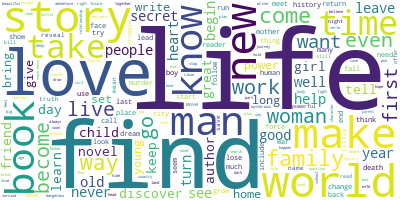

In [14]:
from wordcloud import WordCloud
import itertools

# Join the different processed titles together
list_of_words = list(itertools.chain.from_iterable(data_lemmatized))
long_string = ','.join(word for word in list_of_words)
long_string

# # Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', collocations = False,  random_state=1)

# # Generate a word cloud
wordcloud.generate(long_string)

# # Visualize the word cloud
wordcloud.to_image()


1. **Creación del Diccionario:**  
   Utilizamos `corpora.Dictionary` para crear un diccionario (`id2word`) a partir de los documentos lematizados (`data_lemmatized`). Cada palabra única del corpus se asigna a un identificador único.

2. **Filtrado de Términos Extremos:**  
   Con `id2word.filter_extremes(no_below=1, no_above=0.7)` filtramos los términos:
   - Mantenemos aquellos que aparecen en al menos 1 documento.
   - Eliminamos los términos que aparecen en más del 70% de los documentos, ya que son demasiado comunes y pueden no aportar información relevante al análisis.

3. **Creación del Corpus en Formato BoW:**  
   Definimos `texts` como el conjunto de documentos lematizados y generamos el corpus:
   - Transformamos cada documento en una representación "bag-of-words" utilizando `id2word.doc2bow(text)`, lo que genera una lista de tuplas (id_palabra, frecuencia) para cada documento.

4. **Visualización del Corpus:**  
   Imprimimos las primeras 10 representaciones BoW del corpus para verificar la estructura y el contenido resultante.


In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out tokens that appear in only 1 documents and appear in more than 75% of the documents
id2word.filter_extremes(no_below=1, no_above=0.7)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])
# print(id2word[:10])

[[(0, 1), (1, 2), (2, 1), (3, 2), (4, 2), (5, 1), (6, 2), (7, 1), (8, 2), (9, 2), (10, 1), (11, 2), (12, 2), (13, 3), (14, 1), (15, 2), (16, 1), (17, 3), (18, 2), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 2), (32, 1), (33, 2), (34, 2), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 2), (41, 2), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 3), (51, 2), (52, 2), (53, 3), (54, 2), (55, 2), (56, 2), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 3), (63, 1), (64, 2), (65, 2), (66, 1), (67, 2)], [(3, 2), (28, 1), (33, 1), (56, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (


1. **Importación del Módulo `operator`:**  
   Importamos el módulo `operator` para facilitar el ordenamiento de elementos, utilizando `operator.itemgetter` para ordenar según la frecuencia.

2. **Cálculo de Frecuencia de Palabras:**  
   - Inicializamos listas vacías (`word_freq`, `word_list`) y un diccionario `count_dict` para almacenar la frecuencia de cada palabra.
   - Para cada palabra en los valores del diccionario `id2word` (que contiene todas las palabras únicas del corpus), contamos cuántas veces aparece en `list_of_words` y lo almacenamos en `count_dict`.

3. **Ordenamiento de las Palabras:**  
   - Ordenamos `count_dict` de forma descendente según las frecuencias utilizando `sorted` con `operator.itemgetter(1)`.
   - Seleccionamos las 10 palabras más frecuentes para la visualización.

4. **Visualización con Gráfico de Barras:**  
   - Creamos una figura de tamaño 16x6.
   - Generamos un gráfico de barras que muestra la frecuencia de cada una de las 10 palabras más comunes.
   - Configuramos los ticks del eje X con los nombres de las palabras y los rotamos 70 grados para mejorar la legibilidad.
   - Etiquetamos los ejes: "words" en el eje X y "counts" en el eje Y.

5. **Etiquetado de las Barras:**  
   - Obtenemos el eje actual (`ax`) e iteramos sobre cada barra del gráfico.
   - Para cada barra, añadimos una etiqueta de texto que muestra el valor de la frecuencia, posicionada centrada sobre la barra con un tamaño de fuente de 12 y color gris.

6. **Renderizado del Gráfico:**  
   Finalmente, utilizamos `plt.show()` para mostrar el gráfico de barras, visualizando así las 10 palabras más frecuentes junto a sus respectivos conteos.


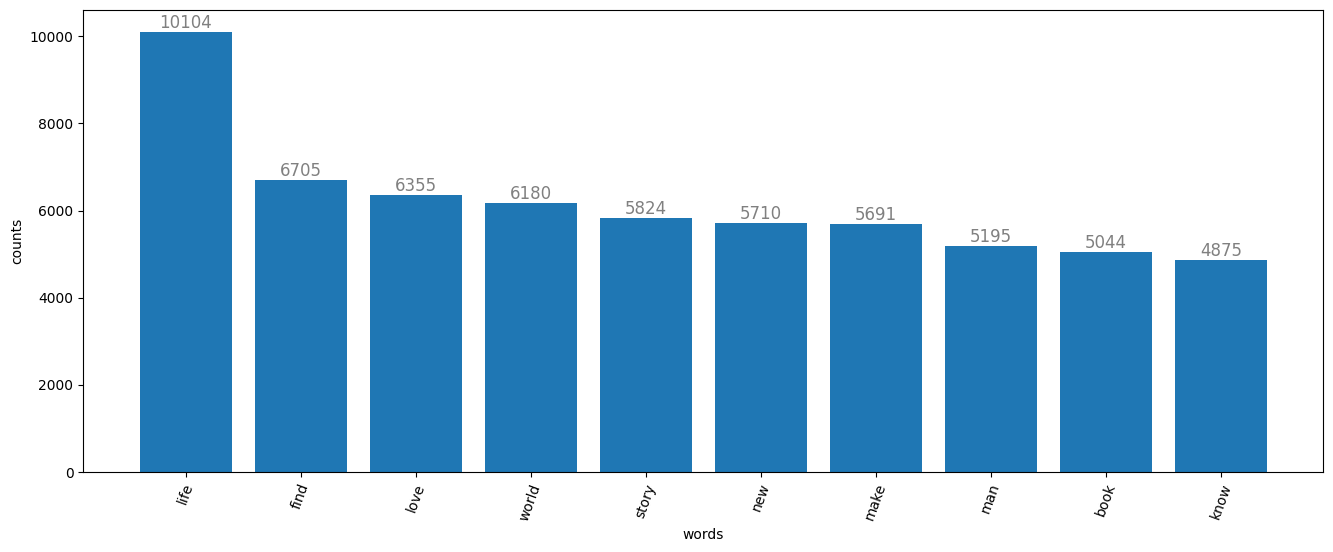

In [16]:
import operator


word_freq = []
word_list = []
count_dict = {}
for n in id2word.values():
    count_dict[n] = list_of_words.count(n)
sorted_dict = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=True)[0:10]

plt.figure(figsize=(16,6))
plt.bar(range(len(sorted_dict)), [val[1] for val in sorted_dict], align='center')
plt.xticks(range(len(sorted_dict)), [val[0] for val in sorted_dict])
plt.xticks(rotation=70)
plt.xlabel('words')
plt.ylabel('counts')

# setting data labels
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
            fontsize=12, color='grey', ha='center', va='bottom')

plt.show()

In [17]:
import pickle

# Suponiendo que 'sorted_dict' es el resultado que quieres guardar:
with open("sorted_dict.pkl", "wb") as f:
    pickle.dump(sorted_dict, f)

In [18]:
with open("sorted_dict.pkl", "rb") as f:
    sorted_dict = pickle.load(f)

---
## 3.2. Tuning de hiperparámetros para el modelo LDA



1. **Construcción del Modelo LDA:**  
   Nosotros utilizamos `gensim.models.LdaMulticore` para construir un modelo LDA (Latent Dirichlet Allocation) aprovechando el procesamiento en paralelo.

2. **Parámetros del Modelo:**  
   - **corpus:** Le pasamos el corpus en formato Bag-of-Words que generamos previamente.
   - **id2word:** Utilizamos el diccionario que mapea los IDs a las palabras.
   - **num_topics=10:** Configuramos el modelo para identificar 10 temas distintos en el corpus.
   - **random_state=100:** Establecemos una semilla aleatoria para garantizar la reproducibilidad de los resultados.
   - **chunksize=100:** Procesamos el corpus en bloques de 100 documentos, lo que nos ayuda a gestionar el uso de memoria y acelera el entrenamiento.
   - **passes=10:** Realizamos 10 pasadas completas sobre el corpus para mejorar la convergencia.
   - **per_word_topics=True:** Permitimos obtener, además de la distribución de temas por documento, la asignación de temas a cada palabra.


In [19]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)


1. **Impresión de Palabras Clave de los Temas:**  
   Utilizamos `pprint(lda_model.print_topics())` para mostrar de forma formateada las palabras clave asociadas a cada uno de los 10 temas identificados por nuestro modelo LDA. Esto nos permite visualizar la composición de cada tema y facilita su interpretación.

2. **Asignación de Temas a los Documentos:**  
   Creamos la variable `doc_lda` al aplicar nuestro modelo LDA al corpus. De esta manera, asignamos a cada documento una distribución de probabilidades sobre los temas, lo que nos indica qué tan representado está cada tema en cada documento.


In [20]:
# Obtenemos Keyword de los 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.018*"food" + 0.012*"recipe" + 0.009*"cook" + 0.009*"money" + '
  '0.007*"kitchen" + 0.006*"get" + 0.005*"make" + 0.005*"cooking" + '
  '0.005*"chef" + 0.005*"eat"'),
 (1,
  '0.017*"story" + 0.008*"love" + 0.007*"book" + 0.006*"life" + 0.006*"find" + '
  '0.005*"child" + 0.005*"make" + 0.005*"adventure" + 0.005*"tale" + '
  '0.005*"come"'),
 (2,
  '0.013*"book" + 0.010*"life" + 0.006*"work" + 0.006*"make" + 0.005*"write" + '
  '0.005*"way" + 0.005*"people" + 0.005*"time" + 0.005*"world" + '
  '0.005*"story"'),
 (3,
  '0.005*"olivia" + 0.005*"alice" + 0.004*"lady" + 0.004*"ship" + '
  '0.004*"marriage" + 0.003*"nasty" + 0.003*"daisy" + 0.003*"kit" + '
  '0.003*"elise" + 0.002*"drake"'),
 (4,
  '0.010*"world" + 0.008*"history" + 0.007*"story" + 0.006*"war" + 0.005*"new" '
  '+ 0.005*"man" + 0.004*"great" + 0.004*"life" + 0.004*"become" + '
  '0.004*"time"'),
 (5,
  '0.010*"love" + 0.009*"life" + 0.009*"mother" + 0.008*"family" + '
  '0.007*"woman" + 0.005*"live" + 0.005*"novel" 


1. **Evaluación del Modelo Base:**  
   Utilizamos `CoherenceModel` de Gensim para evaluar la calidad del modelo LDA que hemos generado. La coherencia es una métrica que mide la consistencia semántica de los temas identificados.

2. **Parámetros de CoherenceModel:**  
   - `model=lda_model`: Pasamos nuestro modelo LDA entrenado.
   - `texts=data_lemmatized`: Utilizamos los textos lematizados para evaluar cómo se agrupan las palabras.
   - `dictionary=id2word`: Proveemos el diccionario que mapea los IDs a las palabras.
   - `coherence='c_v'`: Especificamos el método de coherencia 'c_v', el cual combina medidas de co-ocurrencia de palabras con validación por consenso.

3. **Cálculo y Visualización del Coherence Score:**  
   - Con `get_coherence()` calculamos la puntuación de coherencia del modelo.
   - Finalmente, imprimimos el resultado, proporcionando una medida cuantitativa que nos ayuda a determinar la calidad interpretativa de los temas generados por nuestro modelo.


In [21]:
# Evaluamos modeko - Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3878075759396842



1. **Función de Apoyo para Calcular la Coherencia:**  
   Definimos la función `compute_coherence_values`, que nos permite entrenar un modelo LDA y calcular su puntaje de coherencia. Esta función es útil para evaluar la calidad de los temas generados por el modelo.

2. **Entrenamiento del Modelo LDA:**  
   Dentro de la función, entrenamos un modelo LDA usando `gensim.models.LdaMulticore` con los siguientes parámetros:
   - `corpus`: Nuestro corpus en formato bag-of-words.
   - `id2word`: El diccionario que mapea los IDs a las palabras.
   - `num_topics=10`: Indicamos que el modelo debe identificar 10 temas.
   - `random_state=100`: Fijamos una semilla para asegurar la reproducibilidad.
   - `chunksize=100`: Procesamos el corpus en bloques de 100 documentos para optimizar el rendimiento.
   - `passes=10`: Realizamos 10 pasadas sobre el corpus para mejorar la convergencia del modelo.
   - `per_word_topics=True`: Permitimos obtener la asignación de temas para cada palabra.

3. **Cálculo del Puntaje de Coherencia:**  
   Posteriormente, creamos un objeto `CoherenceModel` utilizando el modelo LDA entrenado, los textos lematizados (`data_lemmatized`), el diccionario (`id2word`) y el método de coherencia `'c_v'`. Finalmente, retornamos el puntaje de coherencia obtenido con `get_coherence()`.

Esta función nos permitirá evaluar de manera sistemática la calidad semántica de los temas generados por el modelo LDA.


In [22]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):

    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

    return coherence_model_lda.get_coherence()


1. **Definición de Parámetros para la Búsqueda de Temas:**  
   Establecemos una lista `topic_param` con diferentes valores (0, 5, 10, 15, 20, 25, 30, 35, 40) que utilizaremos para iterar y ajustar el número de temas en nuestro modelo LDA.

2. **Inicialización de la Lista para Almacenar la Coherencia:**  
   Creamos la lista `coherence_score` para almacenar los puntajes de coherencia que obtengamos en cada iteración.

3. **Iteración y Evaluación:**  
   Para cada valor de `k` en `topic_param`, llamamos a nuestra función `compute_coherence_values` pasándole el corpus, el diccionario y el parámetro `k`.  
   - El valor de `k` se usa para definir el número de temas en el modelo LDA entrenado dentro de la función.
   - Obtenemos el puntaje de coherencia (`cv`) y lo añadimos a la lista `coherence_score`.

4. **Creación de un DataFrame para Visualizar Resultados:**  
   Creamos un DataFrame `param_tuning_coherence` en el que almacenamos los valores de `topic_param` y sus correspondientes puntajes de coherencia en la columna `coherence_score`.

5. **Visualización del DataFrame:**  
   Al final, mostramos el DataFrame para visualizar y comparar los puntajes de coherencia obtenidos para cada valor de temas.


In [23]:
# Iteramos sobre numero de topics. 2-3mins
topic_param = [0,5,10,15,20,25,30,35,40]
coherence_score = []

for k in topic_param:
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(cv)

param_tuning_coherence = pd.DataFrame()
param_tuning_coherence["topic_param"] = topic_param
param_tuning_coherence['coherence_score'] = coherence_score
param_tuning_coherence

# Guardar para evitar ejecutar otra vez
param_tuning_coherence.to_csv("param_tuning_coherence.csv", index=False)

In [24]:
# Guardar para evitar ejecutar otra vez
param_tuning_coherence= pd.read_csv("param_tuning_coherence.csv")


1. **Configuración del Gráfico:**  
   Configuramos una figura con un tamaño de 16x8 para obtener un gráfico claro y legible.

2. **Graficación de los Puntajes de Coherencia:**  
   Utilizamos `plt.plot()` para trazar la relación entre el número de temas (`topic_param`) y los puntajes de coherencia almacenados en `param_tuning_coherence['coherence_score']`. Esto nos permite visualizar cómo varía la coherencia del modelo en función del número de temas.

3. **Personalización del Gráfico:**  
   Añadimos un título al gráfico ("Choosing Optimal LDA Model") y etiquetamos los ejes: "Num Topics" en el eje X y "Coherence Scores" en el eje Y, lo que facilita la interpretación del gráfico.

4. **Visualización del Gráfico:**  
   Finalmente, utilizamos `plt.show()` para mostrar el gráfico generado, permitiéndonos identificar visualmente el número óptimo de temas para nuestro modelo LDA.


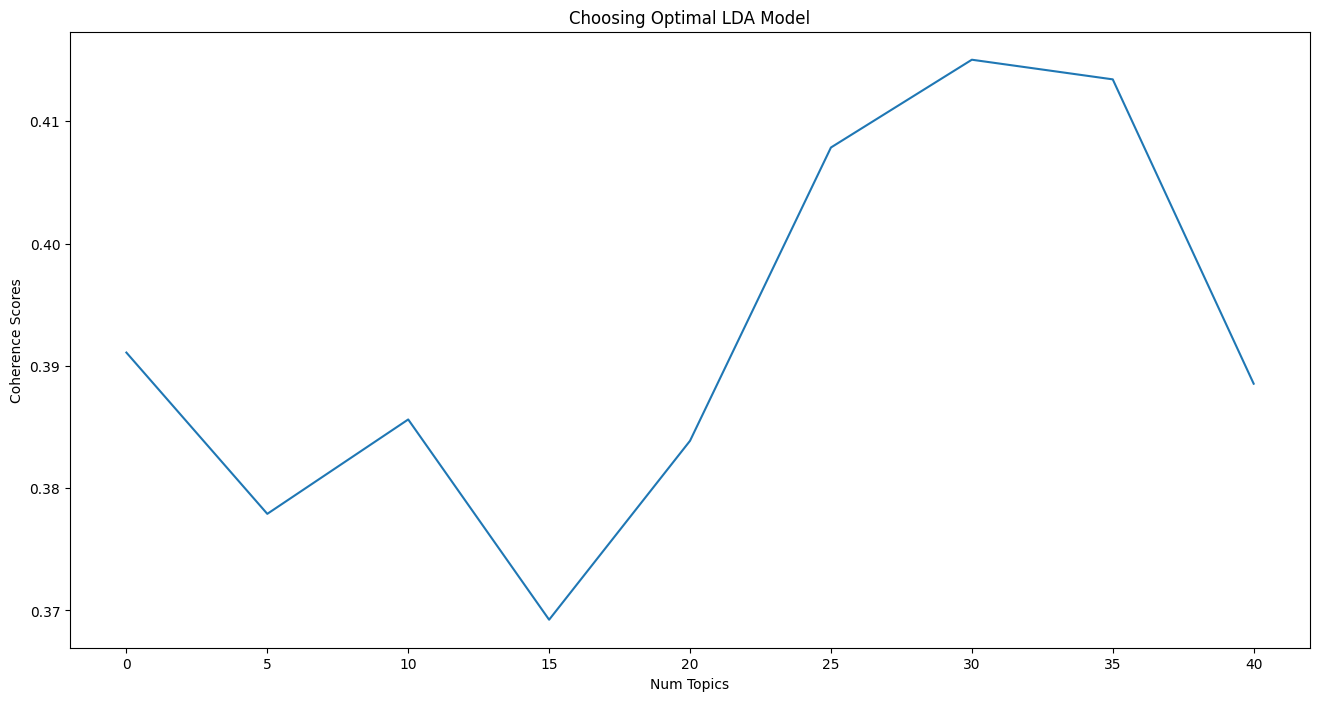

In [25]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, param_tuning_coherence['coherence_score'])

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

---
## 3.3 Modelo LDA final


1. **Construcción del Modelo Final LDA:**  
   Entrenamos el modelo LDA final utilizando `gensim.models.LdaMulticore` con el corpus en formato bag-of-words y el diccionario `id2word`.

2. **Parámetros del Modelo:**  
   - **num_topics=10:** Configuramos el modelo para identificar 10 temas en nuestro corpus.  
   - **random_state=100:** Establecemos una semilla para garantizar que nuestros resultados sean reproducibles.  
   - **chunksize=100:** Procesamos el corpus en bloques de 100 documentos para optimizar el rendimiento.  
   - **passes=10:** Realizamos 10 pasadas sobre el corpus para asegurar una buena convergencia del modelo.  
   - **alpha=0.01:** Establecemos este parámetro para definir la distribución previa de temas por documento; un valor bajo favorece que cada documento se asocie fuertemente a pocos temas.  
   - **eta=0.9:** Ajustamos este parámetro para definir la distribución previa de palabras por tema; modificando este valor controlamos la dispersión de las palabras en cada tema.

Esta celda final nos permite construir el modelo LDA con los parámetros optimizados, preparándolo para generar temas interpretables que posteriormente usaremos en nuestro sistema de recomendación.


In [26]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01, #### mirar que es alpha y eta.
                                           eta=0.9)

In [27]:
lda_model.save('lda_model.gensim')

In [28]:
from gensim.models import LdaMulticore

lda_model = LdaMulticore.load('lda_model.gensim')


1. **Impresión de los Tópicos Generados:**  
   Utilizamos `pprint(lda_model.print_topics())` para mostrar de forma formateada las palabras clave asociadas a cada uno de los 15 tópicos generados por el modelo LDA. Esto nos permite interpretar y validar la composición de cada tópico.

2. **Asignación de Tópicos a los Documentos:**  
   Asignamos a cada documento su distribución de tópicos mediante `doc_lda = lda_model[corpus]`, lo que nos permitirá conocer la relevancia de cada tópico en cada documento para usos posteriores en nuestro sistema de recomendación.


In [29]:
# Print the Keyword in the 15 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"jeeve" + 0.000*"bertie" + 0.000*"wooster" + 0.000*"finnarian" + '
  '0.000*"dahak" + 0.000*"draconian" + 0.000*"perfume" + 0.000*"mutineer" + '
  '0.000*"wodehouse" + 0.000*"curly"'),
 (1,
  '0.004*"dog" + 0.002*"picture_book" + 0.002*"story" + 0.002*"illustration" + '
  '0.001*"animal" + 0.001*"cat" + 0.001*"book" + 0.001*"adventure" + '
  '0.001*"color" + 0.001*"fun"'),
 (2,
  '0.008*"book" + 0.007*"life" + 0.007*"story" + 0.005*"world" + 0.004*"work" '
  '+ 0.004*"make" + 0.004*"new" + 0.004*"time" + 0.004*"write" + 0.003*"way"'),
 (3,
  '0.000*"braylar" + 0.000*"beret" + 0.000*"arki" + 0.000*"calvinism" + '
  '0.000*"bloodsounder" + 0.000*"cynead" + 0.000*"alespell" + 0.000*"traherne" '
  '+ 0.000*"sicarius" + 0.000*"bruge"'),
 (4,
  '0.001*"avenger" + 0.001*"tintin" + 0.001*"watchman" + 0.001*"batman" + '
  '0.000*"world" + 0.000*"story" + 0.000*"collect" + 0.000*"dexter" + '
  '0.000*"marvel" + 0.000*"new"'),
 (5,
  '0.000*"quilt" + 0.000*"life" + 0.000*"quilter" +


1. **Definición de la Función `Sort_Tuple`:**  
   Definimos la función `Sort_Tuple` que toma como entrada una lista o tupla de elementos (cada elemento es una tupla) y devuelve una nueva lista ordenada.

2. **Ordenación con `sorted` y Función Lambda:**  
   Utilizamos la función `sorted` con un parámetro `key` que define una función lambda para extraer el segundo elemento de cada tupla (`x[1]`). Esto nos permite ordenar los elementos basándonos en ese valor.  
   El parámetro `reverse=True` indica que la ordenación se realiza en orden descendente, es decir, de mayor a menor.

Esta función nos permite ordenar de manera eficiente colecciones de tuplas según el valor del segundo elemento, lo que puede ser útil para organizar datos como frecuencias o puntajes.


In [30]:
def Sort_Tuple(tup):
    return(sorted(tup, key = lambda x: x[1], reverse = True))


1. **Inicialización de Listas para Documentos, Tópicos y Probabilidades:**  
   Creamos tres listas vacías: `doc_num`, `topic_num` y `prob` para almacenar, respectivamente, el número del documento, el tópico asignado y la probabilidad asociada a ese tópico.

2. **Visualización de Distribuciones de Tópicos:**  
   Imprimimos la distribución de tópicos para todos los documentos utilizando `lda_model.get_document_topics(corpus)`, lo que nos permite ver la asignación de probabilidades de cada tópico para cada documento.

3. **Iteración sobre Cada Documento:**  
   Para cada documento en el DataFrame:
   - Obtenemos la distribución de tópicos con `lda_model.get_document_topics(corpus[n])`.
   - Añadimos el índice del documento a la lista `doc_num`.
   - Ordenamos la lista de tópicos del documento con la función `Sort_Tuple` para identificar el tópico con mayor probabilidad.
   - Extraemos el tópico principal (el primer elemento tras ordenar) y lo almacenamos en `topic_num`.
   - Extraemos la probabilidad correspondiente a ese tópico y la almacenamos en `prob`.

4. **Integración de los Resultados en el DataFrame:**  
   Añadimos tres nuevas columnas al DataFrame `dataset`:
   - `Doc`: Número del documento.
   - `Topic`: Tópico principal asignado.
   - `Probability`: Probabilidad del tópico principal.

5. **Exportación del DataFrame:**  
   Finalmente, guardamos el DataFrame actualizado en un archivo CSV llamado "doc_topic_matrix.csv" sin incluir el índice, lo que nos permitirá analizar y utilizar la matriz de tópicos en otros entornos o etapas del proyecto.


In [31]:
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus))
for n in range(len(dataset)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
dataset['Doc'] = doc_num
dataset['Topic'] = topic_num
dataset['Probability'] = prob
dataset.to_csv("doc_topic_matrix.csv", index=False)

---
## 3.4. Visualizamos los Topics


1. **Habilitación de pyLDAvis en el Notebook:**  
   Utilizamos `pyLDAvis.enable_notebook()` para habilitar la visualización interactiva de los temas directamente en nuestro entorno de Notebook.

2. **Preparación de la Visualización de Temas:**  
   Con `pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)` preparamos la visualización del modelo LDA.  
   - Se le pasa el modelo LDA (`lda_model`), el corpus en formato bag-of-words (`corpus`) y el diccionario (`id2word`).  
   - El parámetro `sort_topics=False` mantiene el orden original de los temas sin reordenarlos.

3. **Visualización Interactiva:**  
   Al evaluar `LDAvis_prepared`, se despliega una visualización interactiva que nos permite explorar los temas generados, observar la distribución de los temas en el corpus y analizar las palabras clave asociadas a cada uno de ellos.


In [32]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.075928  0.000622       1        1   0.047675
1      0.021091  0.007674       2        1   0.913328
2     -0.215697 -0.075502       3        1  33.047156
3      0.073651  0.002285       4        1   0.063253
4      0.040795 -0.002330       5        1   0.286158
5      0.068940  0.002845       6        1   0.073367
6      0.071092  0.001533       7        1   0.051763
7     -0.271115  0.062351       8        1  65.355963
8      0.063808  0.000786       9        1   0.092825
9      0.071507 -0.000264      10        1   0.068512, topic_info=             Term         Freq        Total Category  logprob  loglift
3            book  4523.000000  4523.000000  Default  30.0000  30.0000
56          story  5293.000000  5293.000000  Default  29.0000  29.0000
1922          dog   520.000000   520.000000  Default  28.0000  28.0000
68      adventure  1039.000000  1039.000000  Default  27.0000  27.0000
28           life  9554.000000  9554.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
301           new     0.094098  5383.034579  Topic10  -9.0984  -3.6685
56          story     0.090300  5293.224061  Topic10  -9.1396  -3.6929
3            book     0.078440  4523.164681  Topic10  -9.2804  -3.6765
2216  incorporate     0.069949    53.007019  Topic10  -9.3950   0.6555
709           man     0.069107  4841.372676  Topic10  -9.4071  -3.8711

[646 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
2588       3  0.872116       account
2588       8  0.127576       account
43502      3  0.348422      adjacent
43502      5  0.348422      adjacent
43502      8  0.348422      adjacent
...      ...       ...           ...
11698      2  0.215209  young_reader
11698      3  0.573892  young_reader
11698      8  0.251078  young_reader
24006      3  0.459599        ½peter
24006      8  0.459599        ½peter

[1317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

---
## 3.5 Top 10 recommended tv shows/movies based on topic modelling



1. **Habilitación de pyLDAvis en el Notebook:**  
   Utilizamos `pyLDAvis.enable_notebook()` para habilitar la visualización interactiva de los temas directamente en nuestro entorno de Notebook.

2. **Preparación de la Visualización de Temas:**  
   Con `pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)` preparamos la visualización del modelo LDA.  
   - Se le pasa el modelo LDA (`lda_model`), el corpus en formato bag-of-words (`corpus`) y el diccionario (`id2word`).  
   - El parámetro `sort_topics=False` mantiene el orden original de los temas sin reordenarlos.

3. **Visualización Interactiva:**  
   Al evaluar `LDAvis_prepared`, se despliega una visualización interactiva que nos permite explorar los temas generados, observar la distribución de los temas en el corpus y analizar las palabras clave asociadas a cada uno de ellos.


In [33]:
def recommend_by_storyline(title, df):
    recommended = []
    top10_list = []

    title = title.lower()
    df['title'] = df['title'].str.lower()
    topic_num = df[df['title']==title].Topic.values
    doc_num = df[df['title']==title].Doc.values

    output_df = df[df['Topic']==topic_num[0]].sort_values('Probability', ascending=False).reset_index(drop=True)

    index = output_df[output_df['Doc']==doc_num[0]].index[0]

    top10_list += list(output_df.iloc[index-5:index].index)
    top10_list += list(output_df.iloc[index+1:index+6].index)

    output_df['title'] = output_df['title'].str.title()

    for each in top10_list:
        recommended.append(output_df.iloc[each].title)

    return recommended

In [34]:
recommend_by_storyline("divergent", dataset)


['Crusader Gold',
 'House Of M',
 'The Lucy Variations',
 'The Hollows Insider',
 'Tony Hogan Bought Me An Ice Cream Float Before He Stole My Ma',
 'Three Strong Women',
 'The Dog That Talked To God',
 'She Said Yes: The Unlikely Martyrdom Of Cassie Bernall',
 'The Snail And The Whale',
 'Wheels']

---
## 3.6. Resumen LDA

- **Preprocesamiento:**  
  Nosotros tokenizamos las descripciones con `sent_to_words`, eliminamos stopwords, generamos bigrams y lematizamos los textos con spaCy, manteniendo solo las categorías relevantes (sustantivos, adjetivos, verbos y adverbios).

- **Construcción del Modelo:**  
  Creamos un diccionario y un corpus en formato bag-of-words, entrenamos un modelo LDA optimizado y evaluamos su coherencia para determinar el número ideal de tópicos.

- **Visualización y Asignación:**  
  Asignamos tópicos a cada documento, generamos una matriz de tópicos y utilizamos pyLDAvis para explorar de forma interactiva la distribución y composición de los temas.


---
## 3.7. Estudio del Error

En el campo de los sistemas de recomendación, la evaluación del error es un desafío particular, ya que no se cuenta con métricas directas y universales como en problemas de clasificación. Durante el desarrollo del proyecto, hemos estudiado diversas técnicas de evaluación para recomendadores, y a continuación, presentamos un resumen de estas metodologías.

### Evaluación Offline

En un primer enfoque, se pueden utilizar evaluaciones offline, que consisten en dividir el dataset en conjuntos de entrenamiento y prueba. Aunque esta metodología es común en tareas de clasificación, en sistemas de recomendación se adaptan métricas específicas, tales como:

- **Hit Rate y Precision@K:** Miden la frecuencia con la que los ítems recomendados incluyen aquellos que el usuario ha consumido o valorado positivamente.
- **NDCG (Normalized Discounted Cumulative Gain):** Valora la posición de los ítems relevantes en la lista de recomendaciones, penalizando aquellos que aparecen en posiciones inferiores.
- **MAP (Mean Average Precision):** Proporciona una medida global de la precisión, considerando la relevancia de las recomendaciones en distintos niveles.

Estas métricas ofrecen una valoración cuantitativa de la calidad del sistema sin requerir pruebas en un entorno en vivo.

### A/B Testing

En este método, se presentan diferentes versiones del recomendador a distintos grupos de usuarios y se comparan sus rendimientos basados en métricas reales, como:

- **Tasa de Conversión:** Proporción de usuarios que realizan una acción deseada, por ejemplo, seleccionar un libro recomendado.
- **Tiempo de Interacción:** Duración de la sesión o tiempo dedicado a explorar las recomendaciones.
- **Feedback Directo:** Valoraciones o comentarios proporcionados por los usuarios sobre la utilidad de las recomendaciones.

El A/B testing permite validar en condiciones reales cómo interactúan los usuarios con el sistema y ajustar, en consecuencia, parámetros o estrategias de recomendación.

### Feedback en Tiempo Real y Modelos de Reinforcement Learning

Otra línea de investigación que hemos estudiado es el uso del feedback en tiempo real, el cual busca adaptar las recomendaciones en función de la interacción inmediata del usuario. Este enfoque puede incluir técnicas de **reinforcement learning**, donde el sistema aprende a optimizar sus sugerencias basándose en recompensas derivadas de comportamientos como clicks o conversiones. Esta técnica muestra un potencial elevado para mejorar la personalización y actualmente se encuentra en una fase exploratoria para muchos escenarios de recomendación.

### Consideraciones Finales

Si bien hemos investigado estas técnicas de evaluación para sistemas de recomendación, un análisis exhaustivo del error en este contexto resulta complejo y se escapa del alcance de este trabajo. Por ello, hemos decidido enfocar nuestro estudio del error en el clasificador basado en LSTM, donde contamos con métricas claras como precisión y pérdida.

En resumen, hemos estudiado metodologías como la evaluación offline, A/B testing y el feedback en tiempo real para mejorar la calidad de los recomendadores. Sin embargo, dado que estas técnicas requieren un enfoque más profundo y específico, las consideramos líneas de investigación futuras para perfeccionar nuestros sistemas de recomendación.